# 初始化

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#這兩行讓 matplotlib 的圖可以顯示中文，同時正常顯示負號
matplotlib.rc('font', family='Microsoft JhengHei')
plt.rcParams['axes.unicode_minus'] = False
import datetime
import seaborn as sns
from sklearn.feature_selection import r_regression as pearsonr

In [2]:
from utils import power_generation_types as power_types #各發電機組屬於哪種發電方式的定義檔

In [3]:
# 定義EDA使用資料的時間範圍
start_date = datetime.datetime.strptime('2023-01-01', '%Y-%m-%d')
end_date = datetime.datetime.strptime('2024-05-31', '%Y-%m-%d')

In [4]:
# 列出台灣自2023年以來的國定假日以及勞動節的日期，通過觀察得知這與總發電量與台電的太陽能購電量息息相關。
holidays = [
    datetime.datetime(2023, 1, 1),
    datetime.datetime(2023, 1, 2),
    datetime.datetime(2023, 1, 20),
    datetime.datetime(2023, 1, 23),
    datetime.datetime(2023, 1, 24),
    datetime.datetime(2023, 1, 25),
    datetime.datetime(2023, 1, 26),
    datetime.datetime(2023, 1, 27),
    datetime.datetime(2023, 2, 27),
    datetime.datetime(2023, 2, 28),
    datetime.datetime(2023, 4, 3),
    datetime.datetime(2023, 4, 4),
    datetime.datetime(2023, 4, 5),
    datetime.datetime(2023, 5, 1),
    datetime.datetime(2023, 6, 22),
    datetime.datetime(2023, 6, 23),
    datetime.datetime(2023, 9, 29),
    datetime.datetime(2023, 10, 9),
    datetime.datetime(2023, 10, 10),
    datetime.datetime(2024, 1, 1),
    datetime.datetime(2024, 2, 8),
    datetime.datetime(2024, 2, 9),
    datetime.datetime(2024, 2, 12),
    datetime.datetime(2024, 2, 13),
    datetime.datetime(2024, 2, 14),
    datetime.datetime(2024, 2, 28),
    datetime.datetime(2024, 4, 4),
    datetime.datetime(2024, 4, 5),
    datetime.datetime(2024, 5, 1),
    datetime.datetime(2024, 6, 10),
    datetime.datetime(2024, 9, 17),
    datetime.datetime(2024, 10, 10),
]

In [5]:
#補班日
adjusted_work_days = [
    datetime.datetime(2023, 1, 7),
    datetime.datetime(2023, 2, 4),
    datetime.datetime(2023, 2, 18),
    datetime.datetime(2023, 3, 25),
    datetime.datetime(2023, 6, 17),
    datetime.datetime(2023, 9, 23),
    datetime.datetime(2024, 2, 3),
]

In [6]:
# 各站經緯度與海拔
site_location_dict = {
    '臺北': {'lat':'25.037658' ,'lon':'121.514853', 'elevation':6.26},
    '高雄': {'lat':'22.73043151' ,'lon':'120.3125156', 'elevation':11.79},
    '嘉義': {'lat':'23.495925' ,'lon':'120.4329056', 'elevation':26.9},
    '東吉島': {'lat':'23.25695' ,'lon':'119.6674667', 'elevation':44.5},
    '臺西': {'lat':'23.701544' ,'lon':'120.197547', 'elevation':12},
    '臺中電廠': {'lat':'24.214642' ,'lon':'120.490744', 'elevation':25},
}

In [7]:
def designate_date_range(df, date_column, start_date, end_date):
    out_df = df[df[date_column] >= start_date]
    out_df = df[df[date_column] <= end_date].reset_index(drop=True)
    return out_df

# 電力部分

資料取自台灣電力公司官網 <a href="https://www.taipower.com.tw/tc/page.aspx?mid=210">https://www.taipower.com.tw/tc/page.aspx?mid=210<a>

## 資料處理

### 原始檔讀取

In [8]:
power_historical_data_filepath = './historical/data/power/power_generation_data.csv'
power_historical_data_df = pd.read_csv(power_historical_data_filepath)
power_historical_data_df['日期'] = [datetime.datetime.strptime(str(s), '%Y%m%d') for s in power_historical_data_df['日期']]
power_historical_data_df = designate_date_range(power_historical_data_df, '日期', start_date, end_date)
power_historical_data_df

,日期,尖峰容量,尖峰負載,備轉容量,備轉率,工業用電,民生用電,核一#1,核一#2,核二#1,...,碧海,立霧,龍澗,卓蘭,水里,其他小水力,大觀二,明潭,風力發電,太陽能發電
0,2023-01-01,29531,25631,3900,15.21,309.788,241.409,0,0,0,...,34.3,68.9,4.1,1.6,4.9,3.9,0.0,21.0,81.0,0.0
1,2023-01-02,30964,26447,4517,17.08,314.262,244.894,0,0,0,...,32.8,64.0,4.1,1.8,4.8,4.0,0.0,23.5,109.1,0.0
2,2023-01-03,35088,29487,5601,18.99,349.277,272.181,0,0,0,...,29.6,63.9,4.1,2.1,4.9,0.0,0.0,22.1,110.2,0.0
3,2023-01-04,34920,29617,5303,17.91,357.823,278.841,0,0,0,...,14.7,48.7,4.1,2.1,4.9,0.0,0.0,22.4,101.0,0.0
4,2023-01-05,33890,30086,3804,12.64,362.197,282.249,0,0,0,...,32.2,65.8,4.1,1.9,4.8,0.0,0.0,22.9,103.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,2024-05-27,41301,34886,6415,18.39,393.662,291.645,0,0,0,...,8.3,4.3,0.5,0.0,0.3,1.7,0.2,6.6,64.0,456.2
513,2024-05-28,40399,32996,7403,22.44,384.927,285.173,0,0,0,...,8.3,23.1,1.4,0.0,1.7,8.0,0.7,8.0,188.9,352.2
514,2024-05-29,44051,33628,10423,31.00,381.572,282.689,0,0,0,...,15.8,15.4,0.5,0.0,1.0,6.1,0.7,7.3,194.3,628.5
515,2024-05-30,41617,35641,5976,16.77,401.379,297.363,0,0,0,...,15.2,35.5,0.8,0.0,1.1,5.1,0.8,8.8,30.5,553.8


In [9]:
# 檢查缺失值
print(f'總共有 {sum(power_historical_data_df.isna().sum())} 筆缺失值')

總共有 0 筆缺失值


### 發電方式匯總

In [10]:
power_type_dict = {
    '日期': power_historical_data_df['日期'],
    '尖峰負載': power_historical_data_df['尖峰負載'],
}
for p_type in power_types.power_generation_type.keys():
    power_type_time_series = np.zeros(len(power_historical_data_df),)
    for generator in power_types.power_generation_type[p_type]:
        power_type_time_series += power_historical_data_df[generator]
    power_type_dict[p_type] = list(power_type_time_series)
power_type_df = pd.DataFrame(power_type_dict)
power_type_df

,日期,尖峰負載,核能,燃煤,民營電廠-燃煤,汽電共生,燃氣,民營電廠-燃氣,燃油,輕油,水力,儲能,風力,太陽能
0,2023-01-01,25631,212.5,560.3,198.4,57.2,1042.6,194.1,18.1,9.0,133.8,21.0,81.0,0.0
1,2023-01-02,26447,256.3,514.9,197.0,90.1,1033.7,217.1,27.4,9.1,130.3,23.5,109.1,0.0
2,2023-01-03,29487,287.2,533.2,210.9,93.0,1014.9,475.4,29.6,9.2,125.1,22.1,110.2,0.0
3,2023-01-04,29617,287.9,548.0,205.6,85.1,1029.5,519.3,21.0,9.4,96.6,22.4,101.0,0.0
4,2023-01-05,30086,287.7,568.8,202.4,85.0,1015.3,517.8,22.9,9.2,129.6,22.9,103.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,2024-05-27,34886,187.7,888.5,173.1,129.7,1029.6,472.6,27.7,10.0,24.8,6.8,64.0,456.2
513,2024-05-28,32996,188.2,836.1,177.7,129.8,904.9,358.5,27.7,10.0,85.5,8.7,188.9,352.2
514,2024-05-29,33628,187.9,761.7,178.6,147.6,914.0,205.2,27.9,8.7,64.8,8.0,194.3,628.5
515,2024-05-30,35641,187.9,890.4,178.7,146.9,949.8,453.4,27.9,9.1,81.6,9.6,30.5,553.8


In [11]:
big_power_type_dict = {
    '日期': list(power_type_df['日期']),
    '尖峰負載': list(power_type_df['尖峰負載'])
}
for big_type in power_types.power_generation_big_type.keys():
    time_series = np.zeros(len(power_historical_data_df),)
    for p_type in power_types.power_generation_big_type[big_type]:
        time_series += power_type_df[p_type]
    big_power_type_dict[big_type] = list(time_series)
big_power_type_df = pd.DataFrame(big_power_type_dict)
big_power_type_df[200:230]

,日期,尖峰負載,核能,燃煤,汽電共生,燃氣,燃油,水力,風力,太陽能
200,2023-07-20,38777,187.1,1321.7,119.5,1610.8,91.0,111.0,11.0,376.4
201,2023-07-21,38406,187.6,1319.5,112.7,1458.8,59.7,86.2,15.5,563.2
202,2023-07-22,33677,187.6,1304.8,57.5,1135.3,39.3,85.0,5.9,519.0
203,2023-07-23,31738,187.6,1292.1,59.0,1383.5,40.3,178.5,0.8,0.0
204,2023-07-24,37723,187.5,1323.0,126.1,1421.3,39.2,92.2,4.1,569.8
205,2023-07-25,38587,188.2,1323.6,130.1,1433.3,101.0,83.3,21.5,549.9
206,2023-07-26,36918,188.0,1310.7,125.3,1589.9,99.9,84.4,38.8,220.6
207,2023-07-27,33952,188.1,1281.8,124.8,1422.9,50.8,118.4,11.6,171.4
208,2023-07-28,32195,187.8,1178.0,125.1,1355.4,38.4,160.3,22.7,124.8
209,2023-07-29,31328,188.5,1033.7,58.2,1303.7,23.3,65.1,47.3,452.0


下圖是台電官網下載資料當中，所有機組發電量加總的值跟尖峰負載那一欄之間的差距，大約正負1~2%，小於0的差距可能可以用表內沒有列出的地熱與生質能發電來解釋，但大於0的差距就不清楚原因了

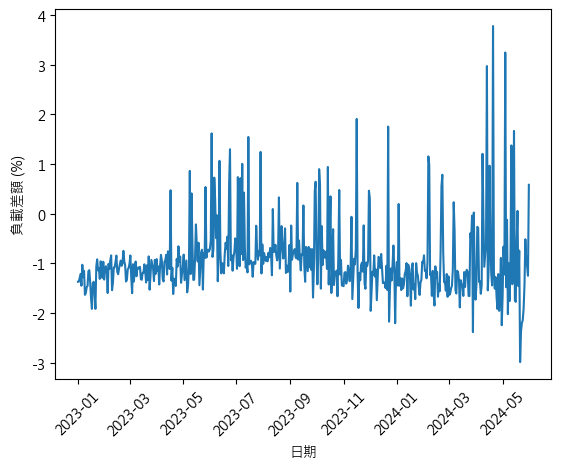

In [12]:
peak_loading = np.array(big_power_type_df['尖峰負載'])
peak_generation = np.sum(np.array(big_power_type_df[[key for key in power_types.power_generation_big_type.keys()]]), axis=1) * 10
plt.plot(big_power_type_df['日期'], (peak_generation - peak_loading) / peak_loading * 100)
_ = plt.xticks(rotation=45)
_ = plt.xlabel('日期')
_ = plt.ylabel('負載差額 (%)')

### 各種發電方式尖峰負載的每月平均

In [13]:
monthly_mean = big_power_type_df.groupby(pd.Grouper(key='日期', freq='ME')).mean().reset_index()
monthly_mean

,日期,尖峰負載,核能,燃煤,汽電共生,燃氣,燃油,水力,風力,太陽能
0,2023-01-31,26760.612903,279.667742,714.587097,89.432258,1280.293548,35.329032,148.287097,80.558065,12.258065
1,2023-02-28,28372.535714,284.414286,734.664286,83.150000,1396.896429,38.507143,143.546429,83.782143,41.057143
2,2023-03-31,29210.096774,231.080645,870.135484,83.129032,1352.132258,25.322581,120.129032,79.125806,126.029032
3,2023-04-30,29624.400000,94.923333,1136.460000,47.253333,1276.270000,27.223333,104.330000,47.960000,197.210000
4,2023-05-31,32074.903226,154.361290,1164.461290,92.754839,1266.887097,27.093548,79.767742,58.632258,337.064516
5,2023-06-30,35040.133333,188.580000,1277.696667,126.260000,1347.893333,47.503333,84.830000,26.523333,388.336667
6,2023-07-31,36399.612903,188.106452,1266.380645,112.558065,1454.670968,68.435484,88.138710,35.316129,406.412903
7,2023-08-31,36143.129032,187.558065,1209.193548,123.522581,1446.122581,54.883871,126.603226,58.635484,379.790323
8,2023-09-30,35140.166667,187.143333,1192.683333,111.576667,1335.526667,58.403333,149.090000,42.710000,409.830000
9,2023-10-31,31567.129032,179.280645,933.832258,107.583871,1358.732258,34.067742,112.180645,128.274194,277.796774


2023年1月與7月，2024年1月與5月，各種發電方式的比例

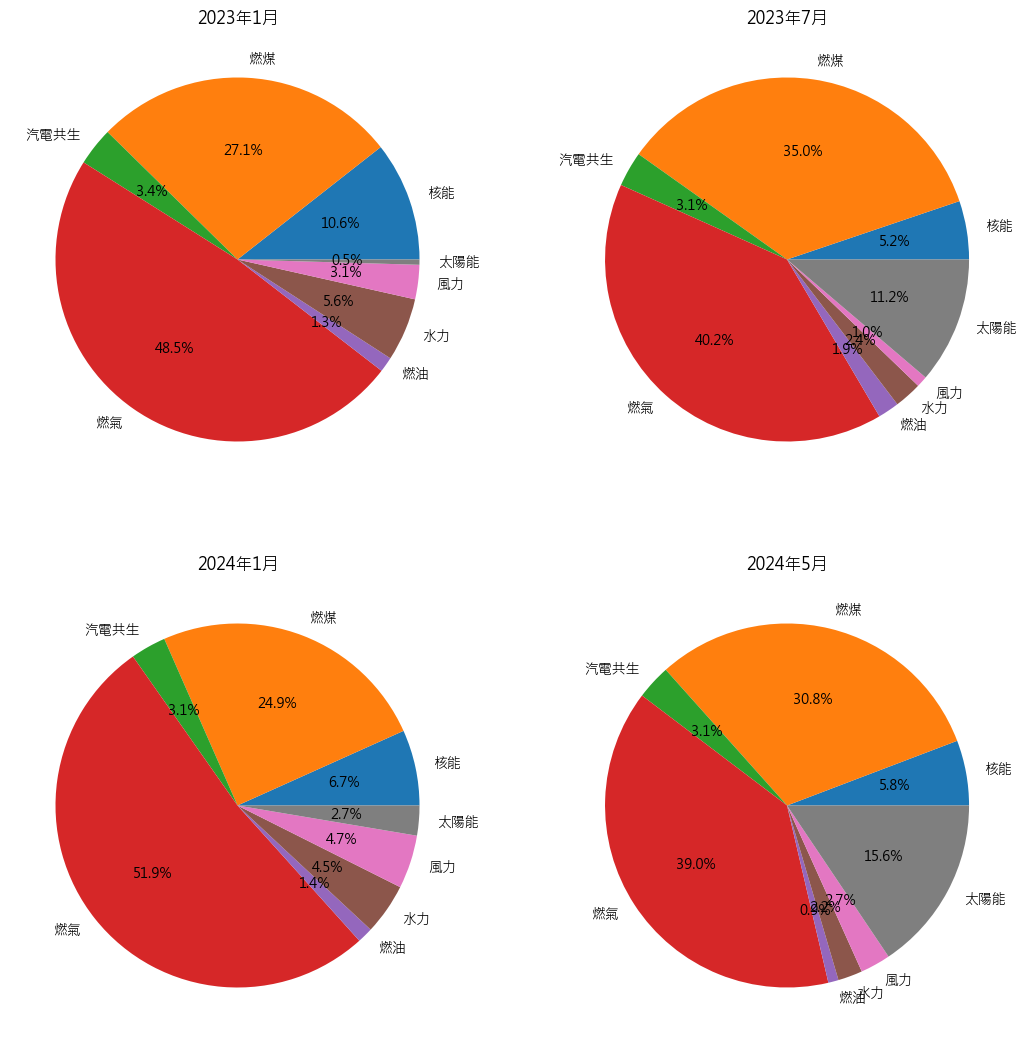

In [14]:
dates = [
    datetime.datetime(2023, 1, 31),
    datetime.datetime(2023, 7, 31),
    datetime.datetime(2024, 1, 31),
    datetime.datetime(2024, 5, 31),
]
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(13, 13)
for i, date in enumerate(dates):
    ax = axes[int(i/2)][i % 2]
    this_df = monthly_mean[monthly_mean['日期'] == date]
    _ = ax.pie(np.array(this_df.iloc[0, 2::]), labels = this_df.keys()[2::], autopct='%.1f%%')
    ax.set_title(f'{date.year}年{date.month}月')

## 初步檢視電力歷史資料

### 尖峰負載

從下圖大約可以看出幾件事：<br>
1. 尖峰負載有季節性變化，夏季可以比冬季高大約 9~10 GW <br>
2. 尖峰負載有短週期變化，深入檢查表格可知這是以七天為週期的變化，周末假日的尖峰負載可以比平日少10%~20% <br>
3. 尖峰負載每年一月或二月會有一個特別低的低谷，深入檢查表格可知那是春節連假時期。

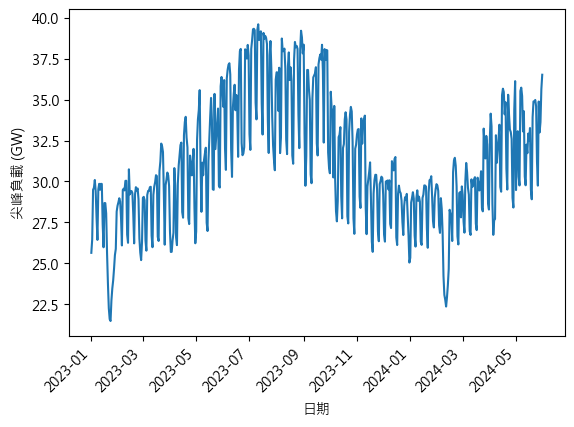

In [15]:
fig, ax = plt.subplots()
fig.autofmt_xdate(rotation= 45)
_ = ax.plot(power_historical_data_df['日期'], power_historical_data_df['尖峰負載'] / 1000)
_ = ax.set_ylabel('尖峰負載 (GW)')
_ = ax.set_xlabel('日期')

### 民生與工業用電

從下圖大約可以看出幾件事：<br>
1. 民生用電的季節週期變化比工業用電大很多 <br>
2. 短週期變化民生與工業都有，相對幅度也似乎差不多 <br>
3. 春節低谷則是工業用電較為明顯

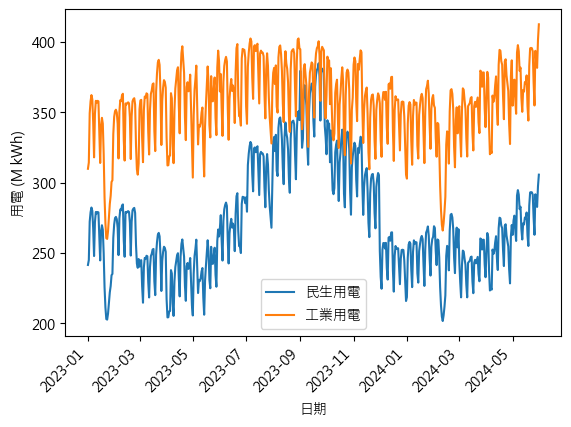

In [16]:
fig, ax = plt.subplots()
fig.autofmt_xdate(rotation= 45)
_ = ax.plot(power_historical_data_df['日期'], power_historical_data_df['民生用電'], label='民生用電')
_ = ax.plot(power_historical_data_df['日期'], power_historical_data_df['工業用電'], label='工業用電')
_ = ax.set_ylabel('用電 (M kWh)')
_ = ax.set_xlabel('日期')
_ = ax.legend()

### 風力與太陽能

從下圖大約可以看出幾件事：<br>
1. 太陽能的尖峰發電量最高可以到達風力的兩到三倍 <br>
2. 太陽能與風力也有短週期變化，深入檢視表格之後發現周日的太陽能數據通常為0，風力的數據常常也很小 (原因不確定)。 <br>
3. 太陽能也有季節性變化，然而看每日數據比較難以確定其趨勢。

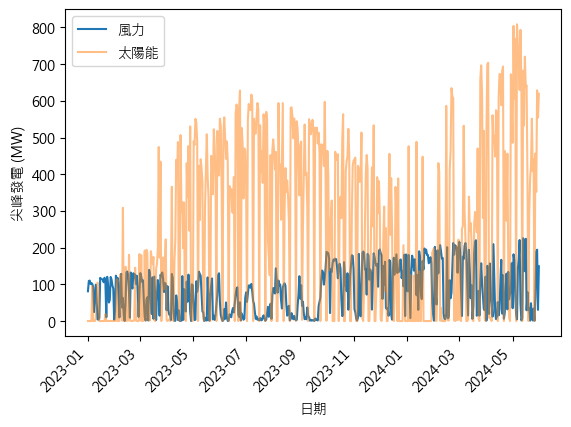

In [17]:
fig, ax = plt.subplots()
fig.autofmt_xdate(rotation= 45)
_ = ax.plot(big_power_type_df['日期'], big_power_type_df['風力'], label='風力')
_ = ax.plot(big_power_type_df['日期'], big_power_type_df['太陽能'], label='太陽能', alpha=0.5)
_ = ax.set_ylabel('尖峰發電 (MW)')
_ = ax.set_xlabel('日期')
_ = ax.legend()

將每月平均值畫出來，就可以比較清楚風電的季節週期，大約是每年10月到隔年3月能發比較多的電

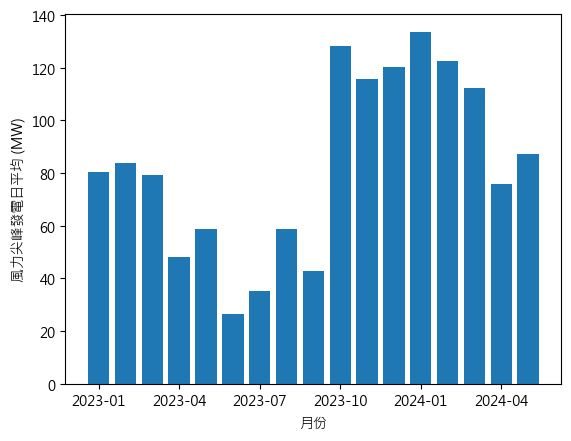

In [18]:
fig, ax = plt.subplots()
ax.bar(x = [*range(len(monthly_mean))], height = monthly_mean['風力'])
_ = ax.set_xticks([*range(0, len(monthly_mean), 3)])
_ = ax.set_xticklabels([datetime.datetime.strftime(d, '%Y-%m-%d')[0:7] for d in monthly_mean['日期'][0::3]])
_ = ax.set_xlabel('月份')
_ = ax.set_ylabel('風力尖峰發電日平均 (MW)')

而太陽能的旺季則在5月到9月，與風電在季節上大致互補

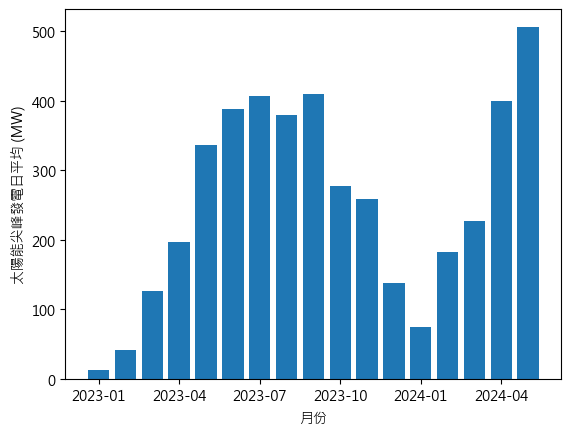

In [19]:
fig, ax = plt.subplots()
ax.bar(x = [*range(len(monthly_mean))], height = monthly_mean['太陽能'])
_ = ax.set_xticks([*range(0, len(monthly_mean), 3)])
_ = ax.set_xticklabels([datetime.datetime.strftime(d, '%Y-%m-%d')[0:7] for d in monthly_mean['日期'][0::3]])
_ = ax.set_xlabel('月份')
_ = ax.set_ylabel('太陽能尖峰發電日平均 (MW)')

將風電與太陽能加總之後的尖峰發電量，從2023年4月開始持續超越核電

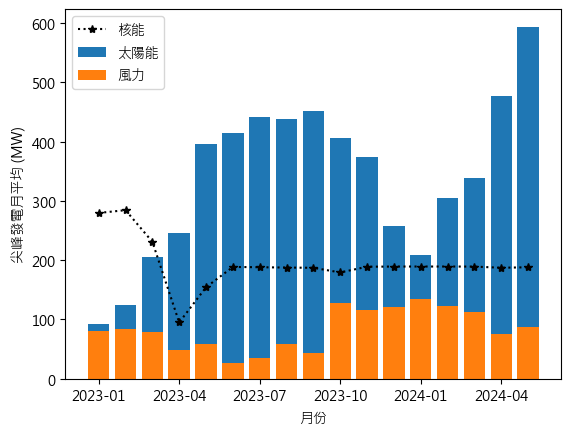

In [20]:
fig, ax = plt.subplots()
ax.bar(x = [*range(len(monthly_mean))], height = monthly_mean['太陽能'] + monthly_mean['風力'], label='太陽能')
ax.bar(x = [*range(len(monthly_mean))], height = monthly_mean['風力'], label='風力')
ax.plot([*range(len(monthly_mean))], monthly_mean['核能'], ':*k', label='核能')
_ = ax.set_xticks([*range(0, len(monthly_mean), 3)])
_ = ax.set_xticklabels([datetime.datetime.strftime(d, '%Y-%m-%d')[0:7] for d in monthly_mean['日期'][0::3]])
_ = ax.set_xlabel('月份')
_ = ax.set_ylabel('尖峰發電月平均 (MW)')
_ = ax.legend()

# 氣象部分

資料取自中央氣象署CODIS氣候觀測資料查詢服務 <a href="https://codis.cwa.gov.tw/StationData">https://codis.cwa.gov.tw/StationData<a>

以下資料選取自六個氣象站，每站的代表意義如下 <br>
臺北：都市氣溫<br>
高雄：都市氣溫，太陽能分布區域日照情形<br>
嘉義：氣溫，太陽能分布區域日照情形<br>
東吉島：氣溫，台灣海峽風力<br>
臺西：氣溫，沿岸陸基風機分布區域風力<br>
臺中電廠：氣溫，沿岸陸基風機分布區域風力<br>

## 資料初步處理

### 讀取

In [21]:
historical_weather_data_filepath = './historical/data/weather/finalized/big_table.csv'
big_df = pd.read_csv(historical_weather_data_filepath).drop('Unnamed: 0', axis=1)
big_df['觀測時間(day)'] = [datetime.datetime.strptime(d, '%Y/%m/%d') for d in big_df['觀測時間(day)']]
big_df = designate_date_range(big_df, '觀測時間(day)', start_date, end_date)
big_df

,站名,觀測時間(day),氣溫(℃),最高氣溫(℃),最低氣溫(℃),相對溼度(%),風速(m/s),風向(360degree),最大瞬間風(m/s),最大瞬間風風向(360degree),降水量(mm),降水時數(hour),日照時數(hour),日照率(%),全天空日射量(MJ/㎡),總雲量(0~10)
0,臺北,2023-01-01,19.3,22.0,16.8,83,3.2,90,12.5,100,1.5,2.6,0.5,4.7,8.98,9.0
1,臺北,2023-01-02,18.5,20.4,16.6,89,2.6,90,11.1,90,2.0,6.6,0.0,0.0,4.00,9.8
2,臺北,2023-01-03,16.1,17.7,14.4,89,3.0,90,12.6,120,T,2.3,0.0,0.0,7.10,10.0
3,臺北,2023-01-04,16.3,17.9,14.5,90,3.1,90,11.0,60,T,5.9,0.2,1.9,6.24,9.0
4,臺北,2023-01-05,19.3,22.2,17.2,90,2.0,90,9.3,90,1.0,2.8,1.3,12.3,9.25,8.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3097,臺中電廠,2024-05-27,28.1,32.1,25.7,84,1.9,169,11.9,225,4.0,NaN,NaN,NaN,NaN,NaN
3098,臺中電廠,2024-05-28,25.2,27.6,23.1,84,3.5,14,15.2,31,47.5,NaN,NaN,NaN,NaN,NaN
3099,臺中電廠,2024-05-29,24.6,27.2,21.4,78,3.5,2,12.1,359,0.0,NaN,NaN,NaN,NaN,NaN
3100,臺中電廠,2024-05-30,27.9,31.2,24.7,81,1.8,196,7.4,340,0.0,NaN,NaN,NaN,NaN,NaN


### 按氣象站分組

In [22]:
G = big_df.groupby('站名')
dfs_seperated_by_station = {}
for tup in G:
    this_df = tup[1].reset_index()
    dfs_seperated_by_station[tup[0]] = this_df

### 檢查缺失值

In [23]:
for station, this_df in dfs_seperated_by_station.items():
    nan_series = this_df.isna().sum()
    total_nan = sum(nan_series)
    print(station)
    print(f'記錄了 {len(this_df)} 天的資料')
    print(f'總共有 {total_nan} 筆缺失值')
    if total_nan > 0:
        print(nan_series[nan_series>0])
    print('='*30)

嘉義
記錄了 517 天的資料
總共有 0 筆缺失值
東吉島
記錄了 517 天的資料
總共有 0 筆缺失值
臺中電廠
記錄了 517 天的資料
總共有 2585 筆缺失值
降水時數(hour)      517
日照時數(hour)      517
日照率(%)          517
全天空日射量(MJ/㎡)    517
總雲量(0~10)       517
dtype: int64
臺北
記錄了 517 天的資料
總共有 0 筆缺失值
臺西
記錄了 517 天的資料
總共有 2585 筆缺失值
降水時數(hour)      517
日照時數(hour)      517
日照率(%)          517
全天空日射量(MJ/㎡)    517
總雲量(0~10)       517
dtype: int64
高雄
記錄了 517 天的資料
總共有 0 筆缺失值


臺中電廠與臺西兩站為自動氣象站，其餘四站為有人駐守的氣象站，所以臺中電廠與臺西兩站有五種資料沒有記錄。

### 風力

由於臺西站於2023年10~11月有約50天沒有平均風速紀錄 (原始表內記為X，因此沒有被前面檢查列為缺失值)，在這邊先補0，所以臺西站這兩個月的平均風速紀錄不可信

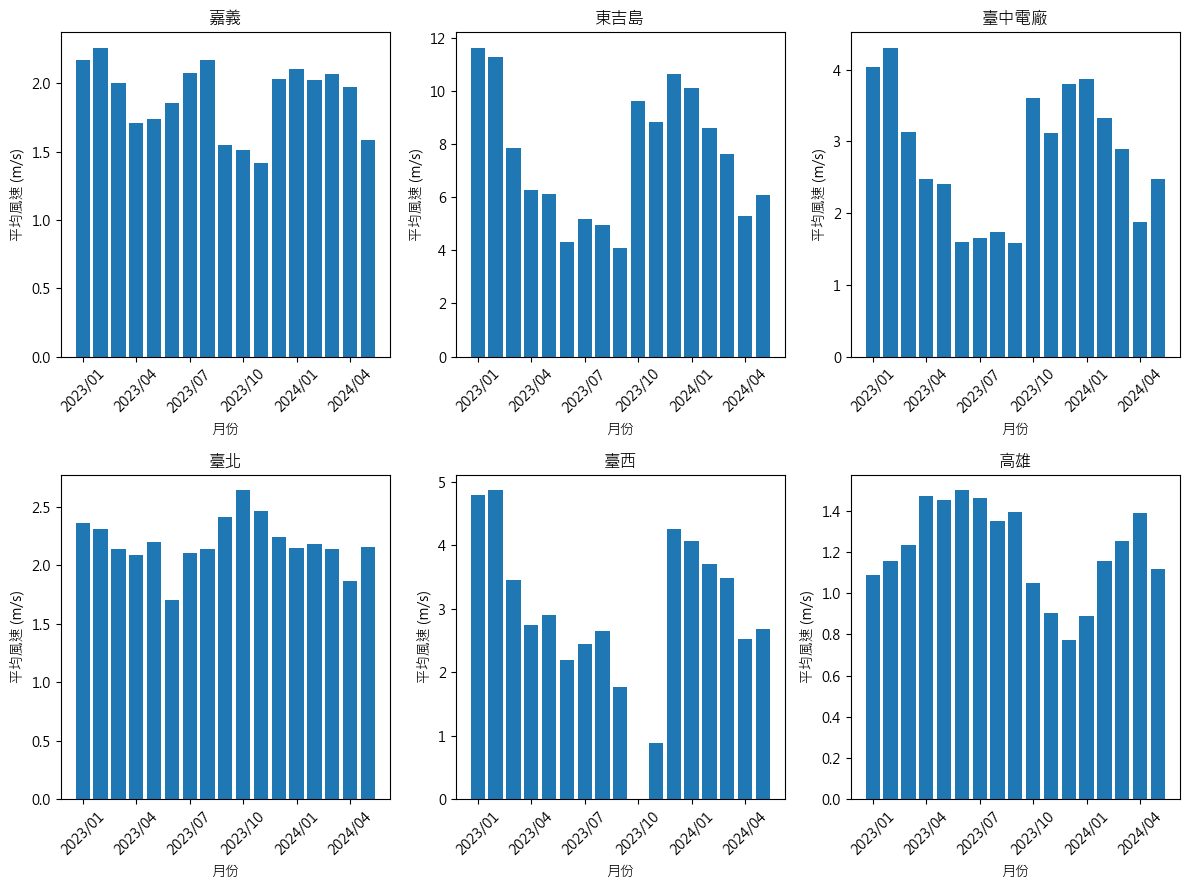

In [24]:
concerned_col = '風速(m/s)'

fig, axes = plt.subplots(2, 3)
fig.set_size_inches((12, 9))

f_id = 0
for station, this_df in dfs_seperated_by_station.items():
    this_small_df = this_df[['觀測時間(day)', concerned_col]]
    this_small_df.loc[:, concerned_col] = [0 if s == 'X' else float(s) for s in this_small_df[concerned_col]]
    monthly_small_df = this_small_df.groupby(pd.Grouper(key='觀測時間(day)', freq='ME')).mean()

    this_ax = axes[int(f_id/3)][f_id % 3]
    this_ax.bar(x = [*range(len(monthly_small_df))], height = monthly_small_df[concerned_col])
    _ = this_ax.set_xticks([*range(0, len(monthly_small_df), 3)])
    _ = this_ax.set_xticklabels([datetime.datetime.strftime(d, '%Y/%m/%d')[0:7] for d in monthly_small_df.index[0::3]], rotation=45)
    _ = this_ax.set_xlabel('月份')
    _ = this_ax.set_ylabel('平均風速 (m/s)')
    _ = this_ax.set_title(station)
    
    f_id += 1
fig.tight_layout()

陣風部分臺西站也缺失了39筆資料 (這次填的是/)，因此臺西站的這張圖也不甚可信

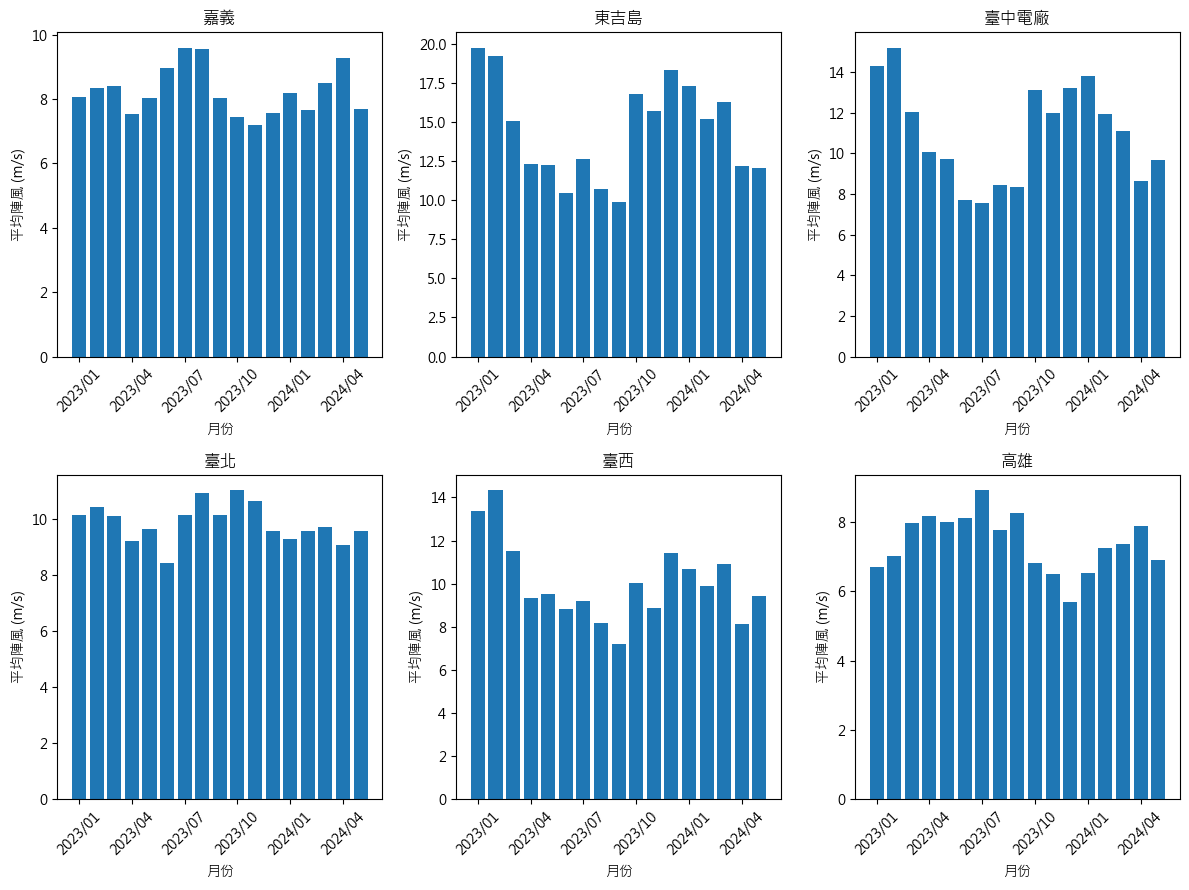

In [25]:
concerned_col = '最大瞬間風(m/s)'

fig, axes = plt.subplots(2, 3)
fig.set_size_inches((12, 9))

f_id = 0
for station, this_df in dfs_seperated_by_station.items():
    this_small_df = this_df[['觀測時間(day)', concerned_col]]
    this_small_df.loc[:, concerned_col] = [0 if s in ['X', '/'] else float(s) for s in this_small_df[concerned_col]]
    monthly_small_df = this_small_df.groupby(pd.Grouper(key='觀測時間(day)', freq='ME')).mean()

    this_ax = axes[int(f_id/3)][f_id % 3]
    this_ax.bar(x = [*range(len(monthly_small_df))], height = monthly_small_df[concerned_col])
    _ = this_ax.set_xticks([*range(0, len(monthly_small_df), 3)])
    _ = this_ax.set_xticklabels([datetime.datetime.strftime(d, '%Y/%m/%d')[0:7] for d in monthly_small_df.index[0::3]], rotation=45)
    _ = this_ax.set_xlabel('月份')
    _ = this_ax.set_ylabel('平均陣風 (m/s)')
    _ = this_ax.set_title(station)
    
    f_id += 1
fig.tight_layout()

### 最高氣溫

如圖 <br>
南部兩個站的年溫差比較低，然後最高溫出現在七月的台北<br>

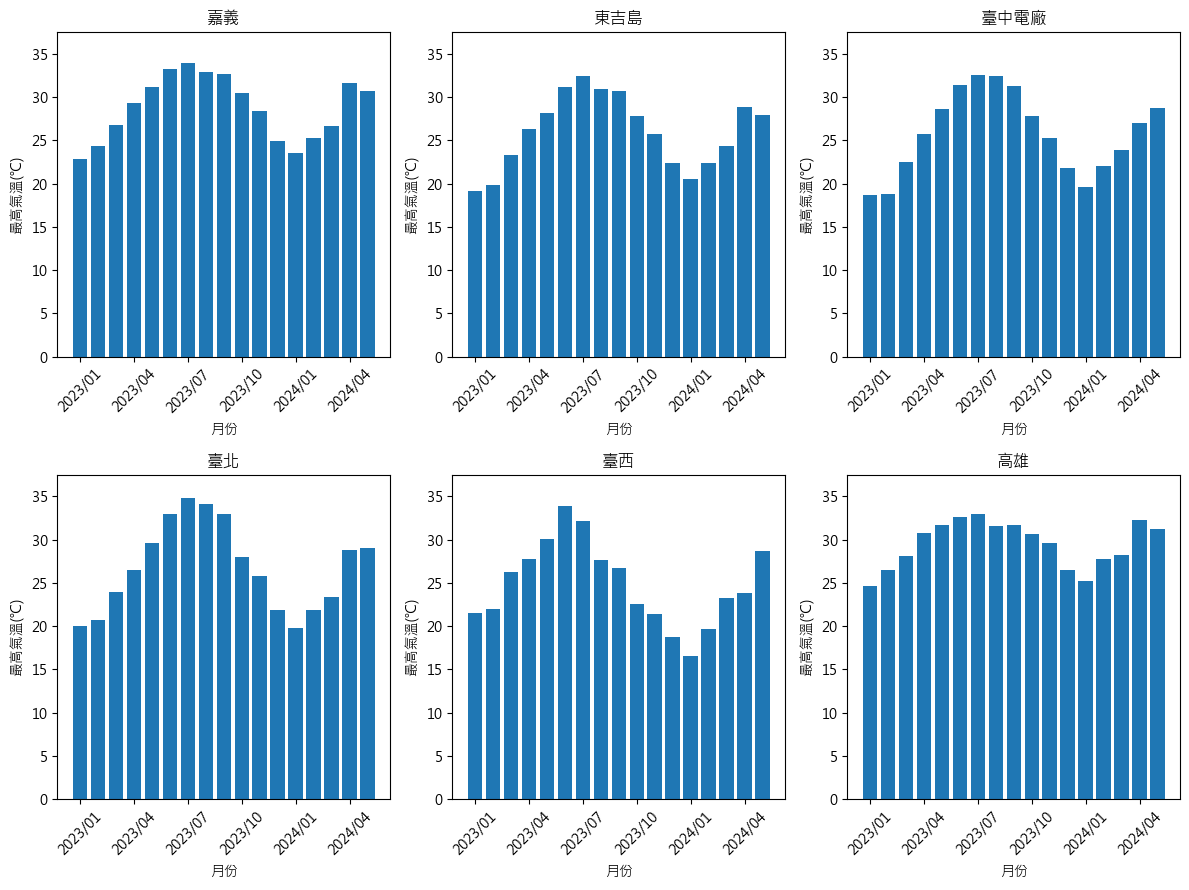

In [26]:
concerned_col = '最高氣溫(℃)'

fig, axes = plt.subplots(2, 3)
fig.set_size_inches((12, 9))

f_id = 0
for station, this_df in dfs_seperated_by_station.items():
    this_small_df = this_df[['觀測時間(day)', concerned_col]]
    this_small_df.loc[:, concerned_col] = [0 if s in ['X', '/'] else float(s) for s in this_small_df[concerned_col]]
    monthly_small_df = this_small_df.groupby(pd.Grouper(key='觀測時間(day)', freq='ME')).mean()

    this_ax = axes[int(f_id/3)][f_id % 3]
    this_ax.bar(x = [*range(len(monthly_small_df))], height = monthly_small_df[concerned_col])
    _ = this_ax.set_ylim([0, 37.5])
    _ = this_ax.set_xticks([*range(0, len(monthly_small_df), 3)])
    _ = this_ax.set_xticklabels([datetime.datetime.strftime(d, '%Y/%m/%d')[0:7] for d in monthly_small_df.index[0::3]], rotation=45)
    _ = this_ax.set_xlabel('月份')
    _ = this_ax.set_ylabel('最高氣溫(℃)')
    _ = this_ax.set_title(station)
    
    f_id += 1
fig.tight_layout()

### 全天空日射量

看單位應該是全天每平方公尺接收到的日照能量有多少MJ，這應該會跟太陽能的發電量直接相關。<br>
之後要研究如何從天氣預報資料來預測這個值。<br>
這個值只有有人駐守的氣象站有紀錄，所以這邊只有四個站的資料。

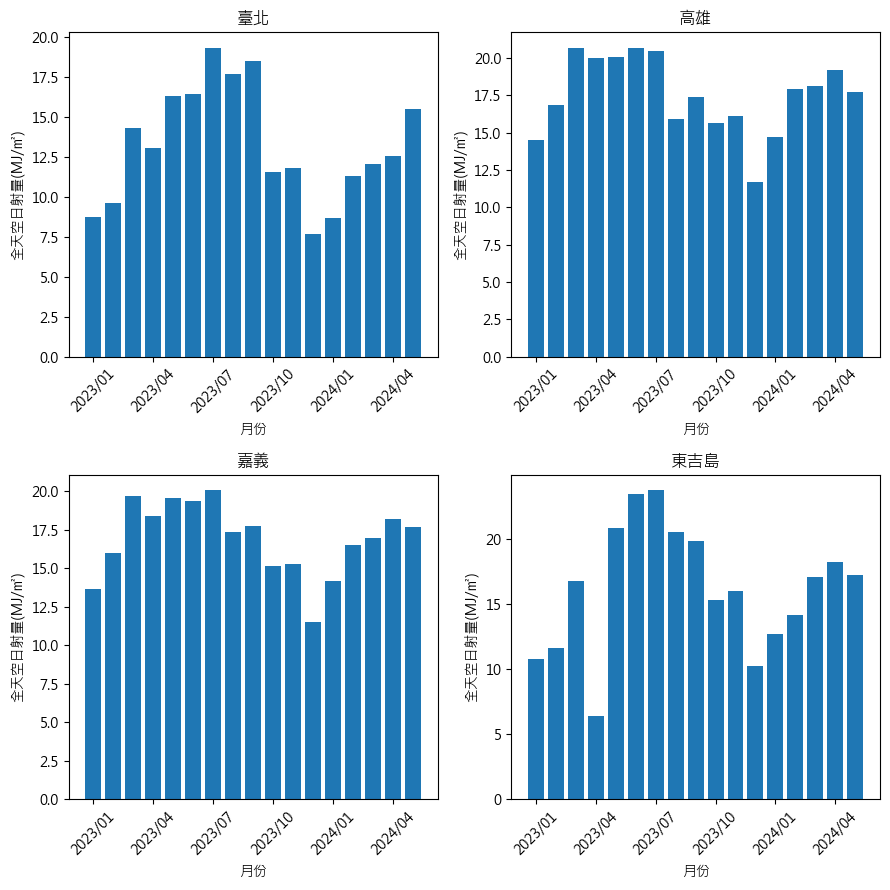

In [27]:
concerned_col = '全天空日射量(MJ/㎡)'

fig, axes = plt.subplots(2, 2)
fig.set_size_inches((9, 9))

f_id = 0
for station in ['臺北', '高雄', '嘉義', '東吉島']:
    this_df = dfs_seperated_by_station[station]
    this_small_df = this_df[['觀測時間(day)', concerned_col]]
    this_small_df.loc[:, concerned_col] = [0 if s in ['X', '/'] else float(s) for s in this_small_df[concerned_col]]
    monthly_small_df = this_small_df.groupby(pd.Grouper(key='觀測時間(day)', freq='ME')).mean()

    this_ax = axes[int(f_id/2)][f_id % 2]
    this_ax.bar(x = [*range(len(monthly_small_df))], height = monthly_small_df[concerned_col])
    _ = this_ax.set_xticks([*range(0, len(monthly_small_df), 3)])
    _ = this_ax.set_xticklabels([datetime.datetime.strftime(d, '%Y/%m/%d')[0:7] for d in monthly_small_df.index[0::3]], rotation=45)
    _ = this_ax.set_xlabel('月份')
    _ = this_ax.set_ylabel('全天空日射量(MJ/㎡)')
    _ = this_ax.set_title(station)
    
    f_id += 1
fig.tight_layout()

# 電力與氣象的綜合探索

## 風電與風速

從台電官網的這個網頁 <a href="https://www.taipower.com.tw/tc/page.aspx?mid=204">https://www.taipower.com.tw/tc/page.aspx?mid=204</a> 可以看出 <br>
目前台灣陸基風電主要分布在苗栗到彰化的沿海，因此這邊取臺中電廠這個位於臺中市龍井區近海的自動氣象站為代表 <br>
而離岸風電主要分布在苗栗縣外海，可是海上的風力狀況跟沿岸會有相當大的不同，因此這邊取位於澎湖縣，但離澎湖列島較遠的東吉島氣象站為海上風力測量的代表 <br>
東吉島面積僅1.77平方公里，並且島上一片平坦，應該可以比較好的代表海面上的氣象狀態。

這邊先直接比較東吉島與臺中電廠兩站測得的平均風速，與全國風電總功率的相關係數。

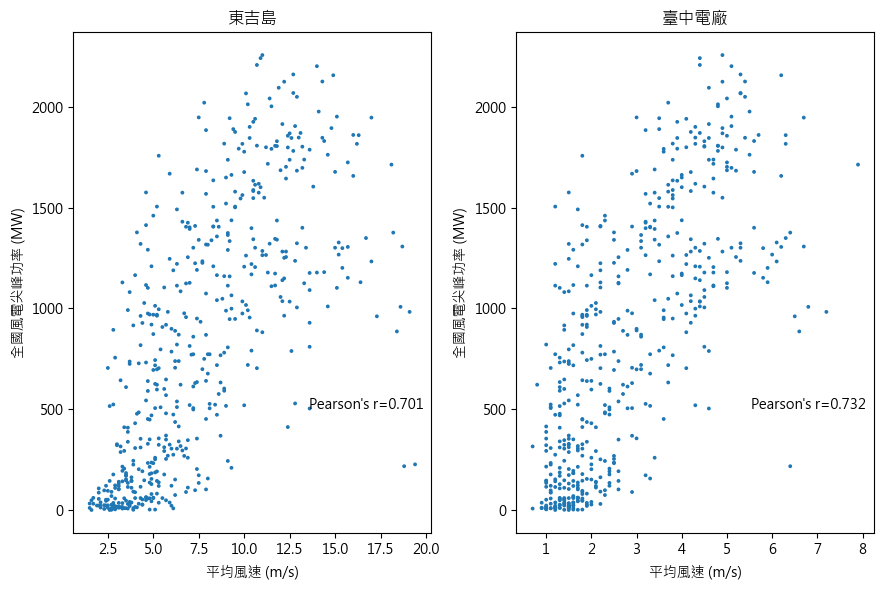

In [28]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(9, 6)
for i, station in enumerate(['東吉島', '臺中電廠']):
    ax = axes[i]
    x = np.array([float(s) for s in big_df[big_df['站名'] == station]['風速(m/s)']]).reshape(-1,1)
    y = np.array(power_historical_data_df['風力發電']) * 10
    ax.scatter(x, y, x*0+3) 
    _ = ax.text(np.max(x) * 0.7, 500, f"Pearson's r={pearsonr(x, y)[0]:.3f}")
    _ = ax.set_xlabel('平均風速 (m/s)')
    _ = ax.set_ylabel('全國風電尖峰功率 (MW)')
    _ = ax.set_title(station)
fig.tight_layout()

上面可以發現測站測到的平均風速確實與風電發電量高度相關 <br>
不過兩個站都有一些資料點測到很高的平均風速，但是風電功率卻相對較低 <br>
我們知道當風速超過一個閾值的時候，風機必須關機以保護機器，這可能是這個現象的成因 <br>
所以下面我們將兩測站測到風速最高的幾個點先排除之後，再來算相關係數。

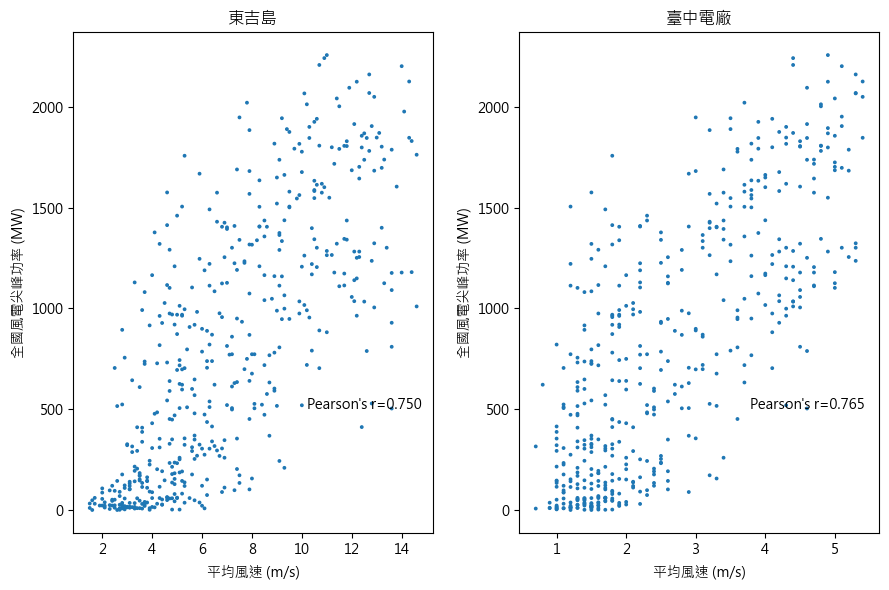

In [29]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(9, 6)
for i, station in enumerate(['東吉島', '臺中電廠']):
    ax = axes[i]
    raw_x = np.array([float(s) for s in big_df[big_df['站名'] == station]['風速(m/s)']])
    raw_y = np.array(power_historical_data_df['風力發電'])
    x_threshold = np.sort(raw_x, axis=0)[int(raw_x.shape[0] * 0.94)]
    x, y = [], []
    for i in range(raw_x.shape[0]):
        if raw_x[i] <= x_threshold:
            x.append(raw_x[i])
            y.append(raw_y[i])
    x = np.array(x).reshape(-1, 1)
    y = np.array(y) * 10
    ax.scatter(x, y, x*0+3) 
    _ = ax.text(np.max(x) * 0.7, 500, f"Pearson's r={pearsonr(x, y)[0]:.3f}")
    _ = ax.set_xlabel('平均風速 (m/s)')
    _ = ax.set_ylabel('全國風電尖峰功率 (MW)')
    _ = ax.set_title(station)
fig.tight_layout()

相關係數確實有一定提升

下圖以最大陣風為橫軸，同樣排除風速最高的幾個點

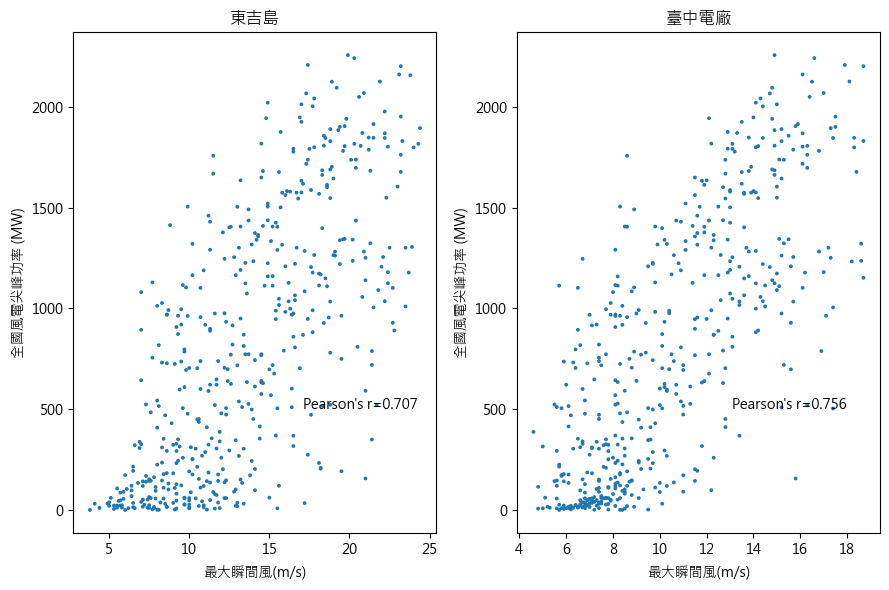

In [30]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(9, 6)
for i, station in enumerate(['東吉島', '臺中電廠']):
    ax = axes[i]
    raw_x = np.array([float(s) if not s == '/' else np.nan for s in big_df[big_df['站名'] == station]['最大瞬間風(m/s)']])
    raw_y = np.array(power_historical_data_df['風力發電'])
    x_threshold = np.sort(raw_x, axis=0)[int(raw_x.shape[0] * 0.94)]
    x, y = [], []
    for i in range(raw_x.shape[0]):
        if raw_x[i] <= x_threshold:
            x.append(raw_x[i])
            y.append(raw_y[i])
    x = np.array(x).reshape(-1, 1)
    y = np.array(y) * 10
    ax.scatter(x, y, x*0+3) 
    _ = ax.text(np.max(x) * 0.7, 500, f"Pearson's r={pearsonr(x, y)[0]:.3f}")
    _ = ax.set_xlabel('最大瞬間風(m/s)')
    _ = ax.set_ylabel('全國風電尖峰功率 (MW)')
    _ = ax.set_title(station)
fig.tight_layout()

## 太陽能與日照量

同樣從台電官網 <a href="https://www.taipower.com.tw/tc/page.aspx?mid=204">https://www.taipower.com.tw/tc/page.aspx?mid=204</a> 可以看出目前台灣的太陽能發電主要分布在彰化縣到屏東縣的廣大中南部區域 <br>
所以這邊取嘉義站與高雄站做為代表，看這兩站測得的日照量與全國太陽能購電量的關係

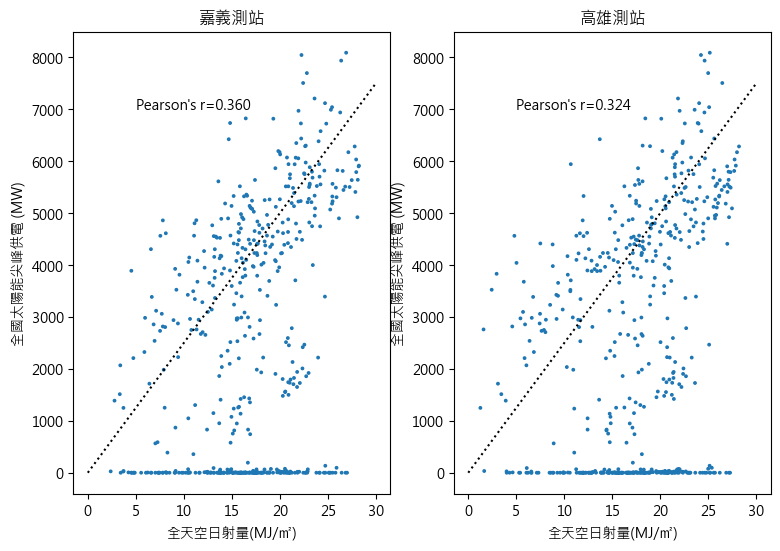

In [31]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches((9,6))
for i, station in enumerate(['嘉義', '高雄']):
    ax = axes[i]
    y = np.array(power_historical_data_df['太陽能發電'])
    x = np.array([float(s) for s in dfs_seperated_by_station[station]['全天空日射量(MJ/㎡)']]).reshape(-1, 1)
    
    ax.scatter(x, y * 10, x*0+3)
    ax.plot([0, 30], [0, 7500] ,':k')
    _ = ax.set_xlabel('全天空日射量(MJ/㎡)')
    _ = ax.set_ylabel('全國太陽能尖峰供電 (MW)')
    _ = ax.set_title(f'{station}測站')
    _ = ax.text(5, 7000, f"Pearson's r={pearsonr(x, y)[0]:.3f}")

前面我們發現太陽能購電量每到周末假日就會很低，甚至常常低到接近 0，<br>
上圖那些 y 接近 0 的資料點，應該大部分屬於周末假日的資料。

另外我用目測畫出一條 y = 250 * x 的線，似乎算是接近大部分資料點所構成的斜率 <br>
所以下圖中我定義 offset = y - 250 * x，並排除周末假日，畫出 offset 對日期的散布圖

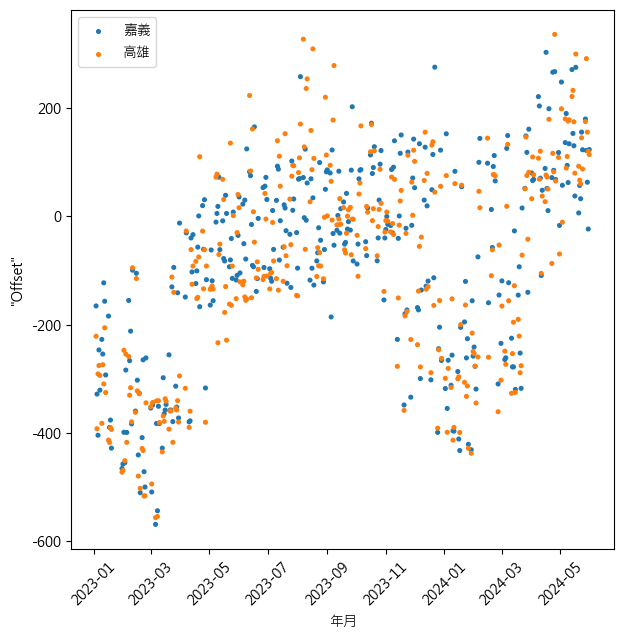

In [32]:
fig, ax = plt.subplots()
fig.set_size_inches((7,7))
for i, station in enumerate(['嘉義', '高雄']):

    test_df = pd.merge(big_power_type_df, big_df[big_df['站名']==station], left_on='日期', right_on='觀測時間(day)')
    test_df['c'] = np.array(test_df['太陽能']) - np.array([float(s) for s in test_df['全天空日射量(MJ/㎡)']]) * 25
    test_df['weekday'] = [d.weekday() if not d in adjusted_work_days else d.weekday() - 0.5 for d in test_df['日期']]
    test_df['month in year'] = [((d - datetime.datetime(d.year, 1, 1)) / datetime.timedelta(1, 0, 0))/365*12 for d in test_df['日期']]

    weekend_df = test_df[test_df['weekday']>=5]
    holiday_df = test_df.loc[[d in holidays for d in test_df['日期']]]
    work_df = test_df.loc[[not d in holidays for d in test_df['日期']]]
    work_df = work_df[work_df['weekday']<5]
    ax.scatter(work_df['日期'], work_df['c'], work_df['c'] * 0 + 7, label = station)
for label in ax.get_xticklabels():
    label.set_rotation(45)
ax.legend()
_ = ax.set_ylabel('"Offset"')
_ = ax.set_xlabel('年月')

從上圖看起來，每年的11月到隔年3月offset會特別的低，而且3月到4月，以及10月到11月之間似乎有不連續的變化，原因不明，但很可能是人為因素。 <br>
另外offset對日期似乎也有一個正斜率，這應該反映了近年來太陽能板設置量的逐漸提升。<br>
至於嘉義與高雄兩站之間則似乎沒有明顯差異。

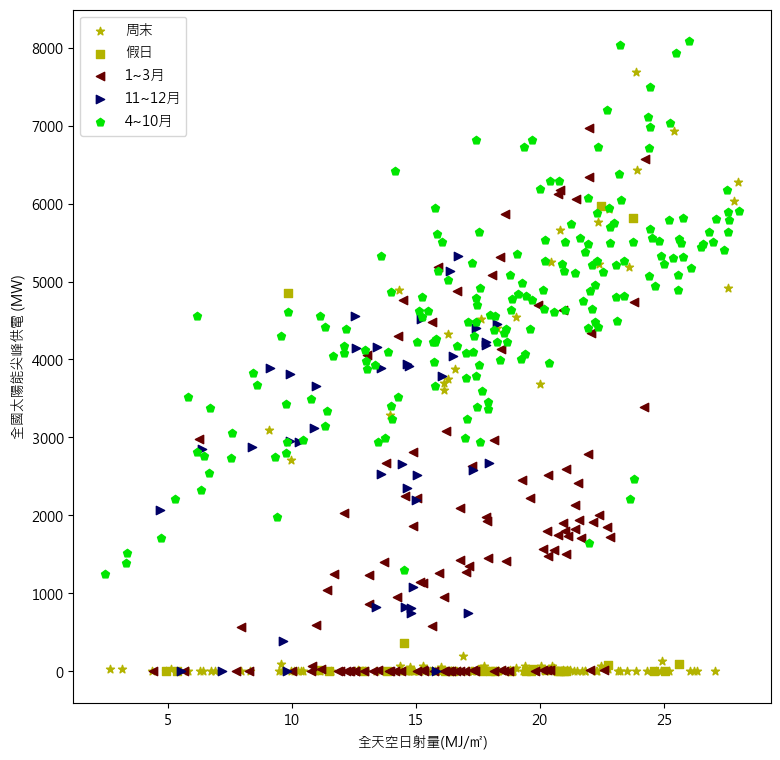

In [33]:
#station = '嘉義'
test_df = pd.merge(big_power_type_df, big_df[big_df['站名']=='嘉義'], left_on='日期', right_on='觀測時間(day)')
test_df['全天空日射量(MJ/㎡)'] = (np.array([float(s) for s in test_df['全天空日射量(MJ/㎡)']]) + np.array([float(s) for s in big_df[big_df['站名']=='高雄']['全天空日射量(MJ/㎡)']])) / 2
test_df['c'] = np.array(test_df['太陽能']) - np.array([float(s) for s in test_df['全天空日射量(MJ/㎡)']]) * 20
test_df['weekday'] = [d.weekday() if not d in adjusted_work_days else d.weekday() - 0.5 for d in test_df['日期']]
test_df['month in year'] = [((d - datetime.datetime(d.year, 1, 1)) / datetime.timedelta(1, 0, 0))/365*12 for d in test_df['日期']]

weekend_df = test_df[test_df['weekday']>=5]
holiday_df = test_df.loc[[d in holidays for d in test_df['日期']]]
work_df = test_df.loc[[not d in holidays for d in test_df['日期']]]
work_df = work_df[work_df['weekday']<5]

early_in_year_df = work_df[work_df['month in year'] <= 3]
late_in_year_df = work_df[work_df['month in year'] >= 10]
middle_in_year_df = work_df.loc[(work_df['month in year'] > 3) & (work_df['month in year'] < 10)]
fig, ax = plt.subplots()
fig.set_size_inches((9,9))
ax.scatter([float(s) for s in weekend_df['全天空日射量(MJ/㎡)']], weekend_df['太陽能'] * 10, marker = '*', label='周末', color=[0.7, 0.7, 0])
ax.scatter([float(s) for s in holiday_df['全天空日射量(MJ/㎡)']], holiday_df['太陽能'] * 10, marker = 's', label='假日', color=[0.7, 0.7, 0])
ax.scatter([float(s) for s in early_in_year_df['全天空日射量(MJ/㎡)']], early_in_year_df['太陽能'] * 10, label='1~3月', marker = '<', color=[0.4, 0, 0])
ax.scatter([float(s) for s in late_in_year_df['全天空日射量(MJ/㎡)']], late_in_year_df['太陽能'] * 10, label='11~12月', marker = '>', color=[0, 0, 0.4])
ax.scatter([float(s) for s in middle_in_year_df['全天空日射量(MJ/㎡)']], middle_in_year_df['太陽能'] * 10, label='4~10月', marker = 'p', color=[0, 0.9, 0])
_ = ax.legend()
_ = ax.set_xlabel('全天空日射量(MJ/㎡)')
_ = ax.set_ylabel('全國太陽能尖峰供電 (MW)')

上圖則是以嘉義站為例，將原本的日照量-太陽能的散布圖按日期分為幾類。
1. 先挑出周末與假日 (以暗黃色表示)
2. 其他工作日按月份分為1-3月 (深紅)，11-12月 (深藍)，與4~10月(螢光綠)

下面兩張表分別列出太陽能購電量大於1000MW的周末及假日，其中：
1. 沒有週日(weekday=6 代表週日, weekday=5 代表週六)
2. 絕大部份樣本的嘉義最高溫都在30度以上，可能因為預期尖峰負載較高，所以正常購買太陽能

In [34]:
holiday_df[holiday_df['太陽能']>100].sort_values('太陽能')[['日期', '尖峰負載', '太陽能', '最高氣溫(℃)', 'weekday']]

,日期,尖峰負載,太陽能,最高氣溫(℃),weekday
486,2024-05-01,29471,485.7,28.2,2.0
173,2023-06-23,31601,581.5,34.3,4.0
271,2023-09-29,31771,597.0,33.6,4.0


In [35]:
weekend_df[weekend_df['太陽能']>100].sort_values('太陽能')[['日期', '尖峰負載', '太陽能', '最高氣溫(℃)', 'weekday']]

,日期,尖峰負載,太陽能,最高氣溫(℃),weekday
230,2023-08-19,31583,270.5,32.1,5.0
251,2023-09-09,30432,309.5,30.9,5.0
279,2023-10-07,30174,328.2,31.0,5.0
153,2023-06-03,32007,360.3,31.4,5.0
272,2023-09-30,30871,369.1,33.5,5.0
181,2023-07-01,32890,370.3,34.9,5.0
503,2024-05-18,29497,375.1,29.0,5.0
146,2023-05-27,29741,388.1,31.4,5.0
160,2023-06-10,31931,432.8,33.2,5.0
510,2024-05-25,31200,441.0,32.3,5.0


下圖橫軸是尖峰負載，縱軸是太陽能發電量除以日照量，這個值特別低的話可能代表台電在這一天購買比較少的太陽能發電 <br>
可以看出這個轉換率跟尖峰負載是有關的，尖峰負載小於27500MW時轉換率幾乎是0，27500~30000MW之間的轉換率也會比較低

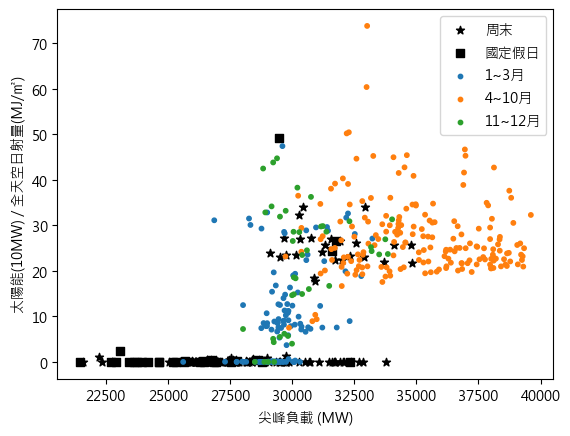

In [36]:
fig, ax = plt.subplots()
ax.scatter(weekend_df['尖峰負載'], weekend_df['太陽能'] / [float(s) for s in weekend_df['全天空日射量(MJ/㎡)']], label='周末', marker='*', color=[0,0,0])
ax.scatter(holiday_df['尖峰負載'], holiday_df['太陽能'] / [float(s) for s in holiday_df['全天空日射量(MJ/㎡)']], label='國定假日', marker='s', color=[0,0,0])
ax.scatter(early_in_year_df['尖峰負載'], early_in_year_df['太陽能'] / [float(s) for s in early_in_year_df['全天空日射量(MJ/㎡)']], early_in_year_df['太陽能']*0+10 ,label='1~3月')
ax.scatter(middle_in_year_df['尖峰負載'], middle_in_year_df['太陽能'] / [float(s) for s in middle_in_year_df['全天空日射量(MJ/㎡)']], middle_in_year_df['太陽能']*0+10 ,label='4~10月')
ax.scatter(late_in_year_df['尖峰負載'], late_in_year_df['太陽能'] / [float(s) for s in late_in_year_df['全天空日射量(MJ/㎡)']], late_in_year_df['太陽能']*0+10 ,label='11~12月')
_ = ax.set_xlabel('尖峰負載 (MW)')
_ = ax.set_ylabel('太陽能(10MW) / 全天空日射量(MJ/㎡)')
_ = ax.legend()

## 尖峰負載與高溫

下圖是臺北高溫與當日尖峰負載之間的關係(只列上班日)，可以看出當臺北當日高溫高於25度時，尖峰負載就會隨著溫度升高而增加 <br>
至於2023與2024這兩年之間的尖峰負載似乎沒有明顯變化

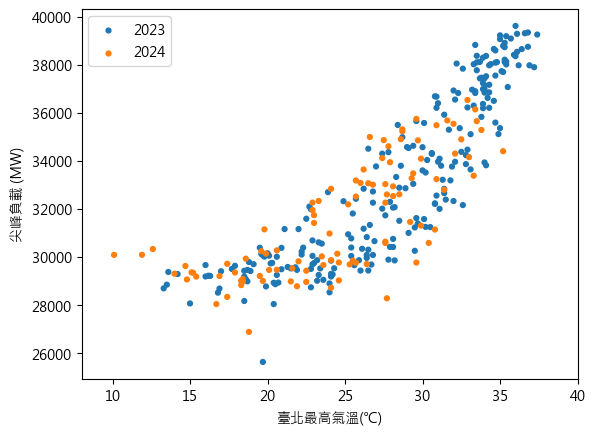

In [37]:
station = '臺北'
test_df = pd.merge(big_power_type_df, big_df[big_df['站名']==station], left_on='日期', right_on='觀測時間(day)')
test_df['weekday'] = [d.weekday() for d in test_df['日期']]
test_df['year'] = [d.year for d in test_df['日期']]

weekend_df = test_df[test_df['weekday']>=5]
holiday_df = test_df.loc[[d in holidays for d in test_df['日期']]]
offday_df = pd.concat([weekend_df, holiday_df], axis=0)
work_df = test_df.loc[[not d in holidays for d in test_df['日期']]]
work_df = work_df[work_df['weekday']<5]

fig, ax = plt.subplots()
this_df = work_df[work_df['year'] == 2023]
ax.scatter([float(s) for s in this_df['最高氣溫(℃)']], this_df['尖峰負載'], this_df['尖峰負載']* 0 + 12, label='2023')
this_df = work_df[work_df['year'] == 2024]
ax.scatter([float(s) for s in this_df['最高氣溫(℃)']], this_df['尖峰負載'], this_df['尖峰負載']* 0 + 12, label='2024')
_ = ax.legend()
_ = ax.set_xlabel(f'{station}最高氣溫(℃)')
_ = ax.set_ylabel('尖峰負載 (MW)')
_ = ax.set_xlim([8, 40])

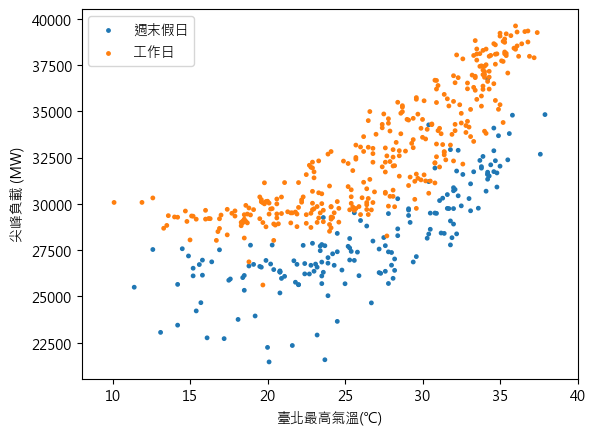

In [38]:
fig, ax = plt.subplots()

ax.scatter([float(s) for s in offday_df['最高氣溫(℃)']], offday_df['尖峰負載'], offday_df['尖峰負載'] * 0 + 6, label='週末假日')
ax.scatter([float(s) for s in work_df['最高氣溫(℃)']], work_df['尖峰負載'], work_df['尖峰負載'] * 0 + 6, label='工作日')
_ = ax.legend()
_ = ax.set_xlabel(f'{station}最高氣溫(℃)')
_ = ax.set_ylabel('尖峰負載 (MW)')
_ = ax.set_xlim([8, 40])

下表則是上圖工作日當中位置最低的那兩個點，兩者都是春節連假之前的最後一個上班日

In [39]:
work_df[work_df['尖峰負載']<28000][['日期', '太陽能', '尖峰負載', '全天空日射量(MJ/㎡)', '最高氣溫(℃)', '相對溼度(%)', '風速(m/s)', '最大瞬間風(m/s)', '降水量(mm)', '日照率(%)']]

,日期,太陽能,尖峰負載,全天空日射量(MJ/㎡),最高氣溫(℃),相對溼度(%),風速(m/s),最大瞬間風(m/s),降水量(mm),日照率(%)
18,2023-01-19,0.0,25614,15.97,19.7,78,3.1,12.2,0.0,87.4
402,2024-02-07,405.6,26865,6.12,18.8,91,2.1,9.6,16.0,2.7


## 日照率與日射量

中央氣象署資料當中的日照率是指從日出到日落當中，日照時數的百分率，這一個數值比較能夠連結到預報當中的「晴」、「多雲」、「陰」等表述。<br>
前面我們已經探索過日射量與太陽能發電量的關係，現在我們要看看日射量與日照率的關係，這邊以嘉義站為例。

In [40]:
test_df = pd.merge(big_power_type_df, big_df[big_df['站名']=='嘉義'], left_on='日期', right_on='觀測時間(day)')

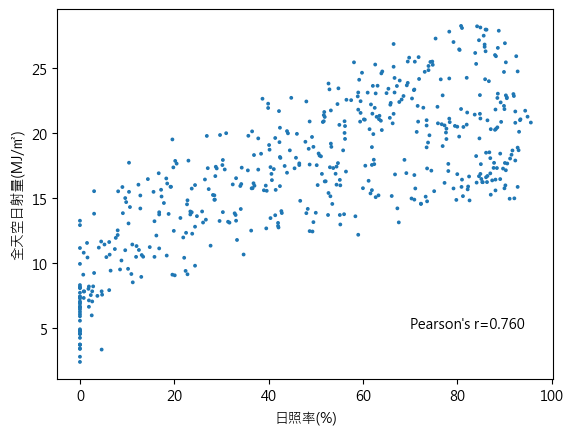

In [41]:
fig, ax = plt.subplots()
y = np.array([float(s) for s in test_df['全天空日射量(MJ/㎡)']])
x = np.array([float(s) for s in test_df['日照率(%)']]).reshape(-1, 1)

ax.scatter(x, y, x*0+3)
_ = ax.set_xlabel('日照率(%)')
_ = ax.set_ylabel('全天空日射量(MJ/㎡)')
_ = ax.text(70, 5, f"Pearson's r={pearsonr(x, y)[0]:.3f}")

由上圖可以發現，在已知日照率的狀況之下，可能的日射量還可以差到一倍左右。

我們知道隨著季節的不同，太陽在天空中的高度，以及每天白天的時長都會不一樣。<br>
有一個天文學家常用的 python 套件叫 pyephem，它有一個功能是可以在給定時間地點的狀況下，告訴你這時某個天體在哪個位置，<br>
這裡我借用了這個套件寫了一個函式，來計算在整天萬里無雲的前提之下，某日某地點的地面整天可以接收到的相對日照量。<br>
以下看看經由這個函式調整過後的日照率，會不會比較貼近日射量。

In [42]:
from utils.sun_light import calculate_all_day_sunlight as sunlight

In [43]:
site = site_location_dict['嘉義'] #嘉義站的經緯度與海拔
test_df['seasonal_sunlight_factor'] = [sunlight(site, date, solar_cell_direction = [180, 90]) for date in test_df['日期']]

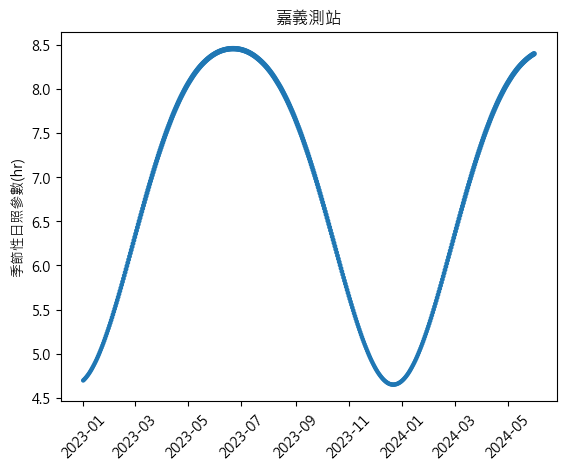

In [44]:
plt.scatter(test_df['日期'], test_df['seasonal_sunlight_factor'], test_df['seasonal_sunlight_factor'])
_ = plt.xticks(rotation=45)
_ = plt.ylabel('季節性日照參數(hr)')
_ = plt.title('嘉義測站')

上圖可以看出，以嘉義站這個幾乎就在北回歸線上的地點，季節性日照參數的最低點大約在冬至，最高點大約在夏至，差距大約為80%

斜率: 2.5198
截距: 8.6888


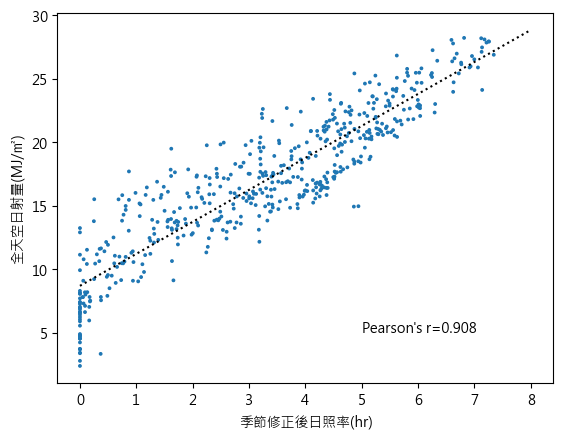

In [46]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots()
y = np.array([float(s) for s in test_df['全天空日射量(MJ/㎡)']])
x = np.array([float(s) for s in test_df['日照率(%)']] * test_df['seasonal_sunlight_factor']).reshape(-1, 1) / 100

model = LinearRegression()
_ = model.fit(x, y)

ax.scatter(x, y, x*0+3)
ax.plot([0, 8], [model.intercept_, model.intercept_ + model.coef_[0]*8],':k')
_ = ax.set_xlabel('季節修正後日照率(hr)')
_ = ax.set_ylabel('全天空日射量(MJ/㎡)')
_ = ax.text(5, 5, f"Pearson's r={pearsonr(x, y)[0]:.3f}")

print(f'斜率: {model.coef_[0]:.4f}')
print(f'截距: {model.intercept_:.4f}')

從上圖可以看出，考慮季節因素之後，日照率與日射量的相關係數顯著提升 <br>
這當中剩下的不確定因素，可能是在相同日照時數的前提之下，雲層遮住太陽的時間如果接近中午，或是接近凌晨或黃昏，對於日射量也會造成影響<br>
另外同樣是被雲層遮住，雲層的厚度也會影響太陽光穿透雲層，照到地面的比例